# <span style='color:red'>Project 2</span>

### In this project we aim to construct a portfolio using daily data by solving an optimization problem.

In [ ]:
import csv
import sys
import scipy.io
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import yfinance as yfin
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns
import math
import matplotlib.pyplot as plt

## <span style='color:red'> Preprocessing Data ##


In [ ]:

start_date = '2017-01-01' # inclusive
end_date = '2019-01-02' # exclusive

asset_lst = ['A','AAP','AAPL','GOOG','GS', 'TSLA']

MyData = yfin.download(asset_lst,start=start_date,end=end_date)
MyData = MyData.dropna()
MyData_close = MyData['Close']
MyData_open = MyData['Open']

returns = (MyData_close - MyData_open) / MyData_open
asset_lst = list(returns.columns)
returns_arr= returns.values
expected_returns = np.array(returns.mean())

[*********************100%***********************]  6 of 6 completed


## <span style='color:red'> Task 1: Portfolio Optimization Method 1 ##


In [ ]:
def objective(weights, returns_arr, theta, pi):
    T, n = returns_arr.shape
    expected_returns = np.mean(returns_arr, axis=0)
    first_term = -np.dot(expected_returns, weights) #negative expected return term
    excess_returns = returns_arr - expected_returns
    weighted_excess_returns = np.dot(excess_returns,weights)
    risk_term = (np.mean(np.abs(weighted_excess_returns) ** pi)) ** (1 / pi) #risk term
    total_objective = first_term + theta * risk_term #impact of risk term is affected by theta
    return total_objective

def portfolio_optimization(theta, pi,returns_arr):

    expected_returns = np.mean(returns_arr, axis = 0)
    T, n = returns_arr.shape
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # sum of weights = 1
                {'type': 'ineq', 'fun': lambda x: x})  # no shorting

    x0 = np.ones(n) / n  # initial guess is equal weighting
    result = minimize(objective, x0, args=(returns_arr, theta, pi), constraints=constraints, method='SLSQP',options={'ftol': 1e-12})
    optimal_weights = result.x

    return optimal_weights

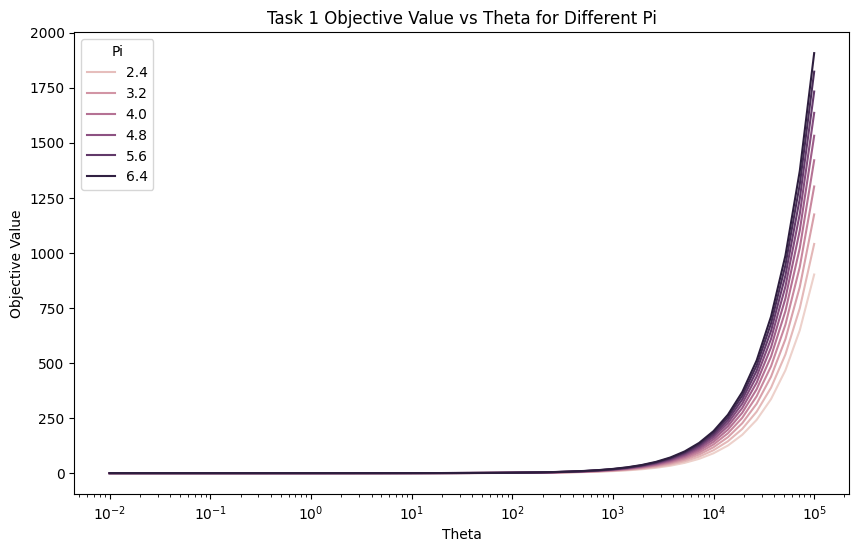

In [ ]:
# 10 pi values from 2 to 6.5
pi_values = np.linspace(2, 6.5, 10)
# 50 theta values from 0.01 to 100,000
theta_values = np.logspace(-2, 5, 50)
# Where we save our result
results = []
# Looping through different pi and theta values
for pi in pi_values:
    for theta in theta_values:
        # Gaining optimal weights
        optimal_weights = portfolio_optimization(theta,pi,returns_arr)
        score = objective(optimal_weights,returns_arr,theta,pi)
        results.append({
            'pi': pi,
            'theta': theta,
            'objective': score,
            'weights': optimal_weights
            })

results_original = pd.DataFrame(results) #this table stores all our weight strategies for different theta and pi values

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_original, x='theta', y='objective', hue='pi')
plt.title('Task 1 Objective Value vs Theta for Different Pi')
plt.xlabel('Theta')
plt.ylabel('Objective Value')
plt.legend(title='Pi')
plt.xscale('log')
plt.show()

## <span style='color:red'> Task 2: Portfolio Optimization with PCA.</span>


### Portfolio Optimization Algorithm

In [ ]:
#classic markowitz portfolio optimizaiton that only uses theta
def mean_variance_optimization(theta, expected_returns, cov_matrix):
    n = len(expected_returns)

    def objective(x):
        return_term = np.dot(expected_returns, x)
        risk_term = x.T @ cov_matrix @ x
        return -return_term + theta * risk_term

    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # sum of weights = 1
                   {'type': 'ineq', 'fun': lambda x: x}]  # No shorting

    x0 = np.ones(n) / n  # Initial guess for equal weights
    result = minimize(objective, x0, constraints=constraints, method='SLSQP', options={'ftol': 1e-12})
    return result.x

#function to get magnitude of objective from sample weights
def test_portfolio2(theta, weights, expected_returns, cov_matrix):
    return_term = np.dot(expected_returns, weights)
    risk_term = weights.T @ cov_matrix @ weights
    #print(return_term,risk_term)
    return -return_term + theta * risk_term

### PCA Intuition

Since n=6 is a small sample size, it can be difficult to clearly identify the "elbow" in the explained variance ratios, which helps determine the optimal number of principal components (k). By sampling a larger collection of stocks (n=40), we can better observe how the variance explained by each principal component drops off. This gives us a better intuition for choosing k (looks like k=1 or k=2 in this case).

Beyond this block, we don't use any of these results anywhere


[*********************100%***********************]  40 of 40 completed
<ipython-input-11-52e1e118a62a>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns_big = returns_big.fillna(method='ffill')


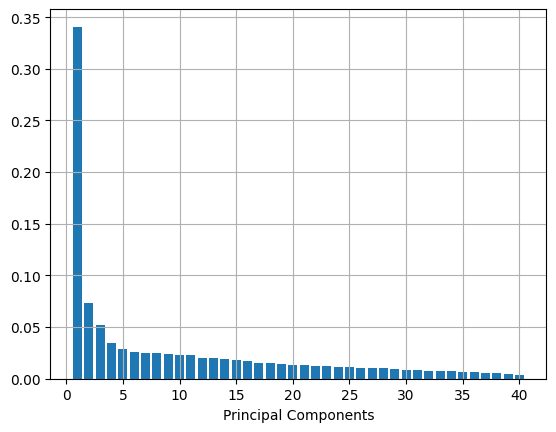

In [ ]:
#bigger asset list for intuition comparison
asset_lst_big = ['A', 'AAP', 'AAPL', 'GOOG', 'GS', 'TSLA', 'NVDA', 'IBM', 'CRSP', 'SMCI', 'AMD', 'META', 'F',
 'XOM', 'KO', 'CVX', 'HD', 'UPS', 'BA', 'WMT', 'CAT', 'BABA', 'MMM', 'PEP', 'BAC', 'CSCO',
 'JNJ', 'HON', 'INTC', 'MRK', 'WFC', 'PYPL', 'MSFT','NEE','LIN','PLD','TDY','SEDG','DIS','CSCO','EDIT']
MyData = yfin.download(asset_lst_big,start=start_date,end=end_date)
MyData = MyData.dropna()
MyData_adj_close = MyData['Adj Close']
returns_big = MyData['Adj Close'].pct_change().dropna()
returns_big = returns_big.fillna(method='ffill')

scaler_big = preprocessing.StandardScaler()
returns_scaled_big = scaler_big.fit_transform(returns_big)

pca_big = PCA()
pca_big.fit(returns_scaled_big)
explained_variance_ratio = np.cumsum(pca_big.explained_variance_ratio_)

num_components = len(pca_big.explained_variance_ratio_)
temp = np.linspace(1, num_components, num_components)
plt.bar(temp, pca_big.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.grid()
plt.show()

### Use PCA in Optimization

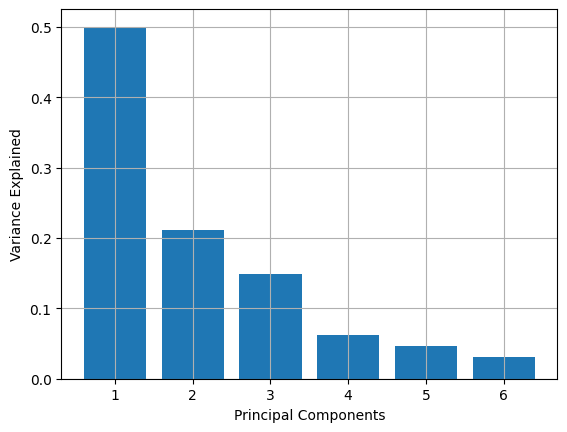

2 principal components explain 71.16% of the total variance
Original Covariance Matrix:


,0,1,2,3,4,5
0,0.000128,0.000040,0.000061,0.000081,0.000065,0.000085
1,0.000040,0.000288,0.000036,0.000038,0.000052,0.000050
2,0.000061,0.000036,0.000135,0.000100,0.000069,0.000108
3,0.000081,0.000038,0.000100,0.000164,0.000082,0.000122
4,0.000065,0.000052,0.000069,0.000082,0.000168,0.000083
5,0.000085,0.000050,0.000108,0.000122,0.000083,0.000630


New Covariance Matrix (from PCA):


,0,1,2,3,4,5
0,0.000053,0.000083,0.000057,0.000067,0.000063,0.000101
1,0.000083,0.000183,0.000084,0.000099,0.000108,0.000011
2,0.000057,0.000084,0.000063,0.000074,0.000068,0.000129
3,0.000067,0.000099,0.000074,0.000086,0.000079,0.000148
4,0.000063,0.000108,0.000068,0.000079,0.000077,0.000098
5,0.000101,0.000011,0.000129,0.000148,0.000098,0.000615


In [ ]:
# Calculate original covariance matrix
cov_matrix = returns.cov().values

# Apply PCA
pca = PCA()
pca.fit(returns_arr)

# Plot the explained variance ratio
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.grid()
plt.show()

# Select number of principal components (k)
def pca_to_cov_matrix(k,pca,verbose=False):
    cumulative_var = np.sum(pca.explained_variance_ratio_[:k])
    if verbose:
        print(f'{k} principal components explain {round(cumulative_var * 100, 2)}% of the total variance')

    # Get principal components and compute the new covariance matrix
    principal_components = pca.transform(returns_arr)[:, :k]
    factor_cov_matrix = np.cov(principal_components.T)
    factor_loadings = pca.components_[:k].T

    # Reconstruct the covariance matrix
    new_cov_matrix = (factor_loadings @ factor_cov_matrix @ factor_loadings.T)
    return new_cov_matrix

new_cov_matrix = pca_to_cov_matrix(2,pca,verbose=True)
# Display original and new covariance matrices
print('Original Covariance Matrix:')
display(pd.DataFrame(cov_matrix))

print('New Covariance Matrix (from PCA):')
display(pd.DataFrame(new_cov_matrix))


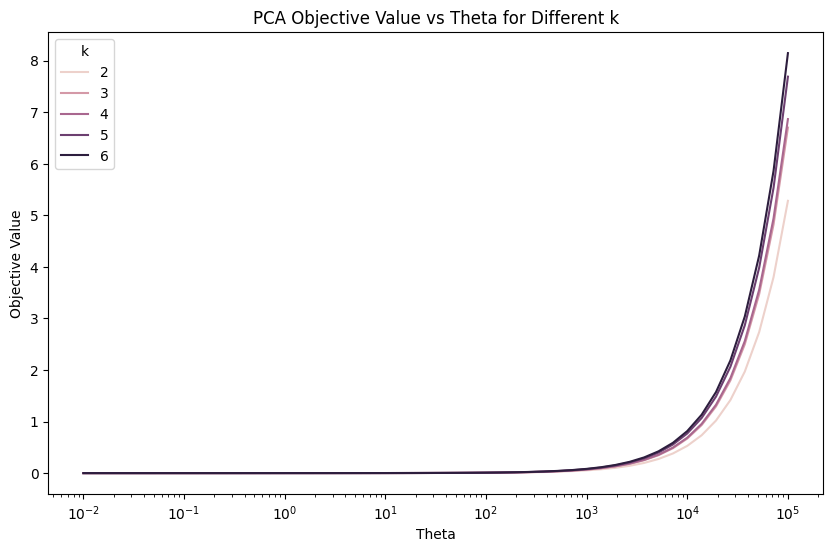

In [ ]:
theta_values = np.logspace(-2, 5, 50)  # 50 values from 0.001 to 100,000

#Calculate optimal weights for different theta and k values
def iterations(theta_values,expected_returns,pca):
    results = []
    for theta in theta_values:
        for k in range(2,7):
            cov = pca_to_cov_matrix(k,pca)
            optimal_weights = mean_variance_optimization(theta,expected_returns,cov)
            score = test_portfolio2(theta, optimal_weights, expected_returns, cov)
            results.append({
                'theta': theta,
                'objective': score,
                'k': k,
                'weights': optimal_weights
            })
    return pd.DataFrame(results)

results_pca = iterations(theta_values,expected_returns,pca) #this table stores all our PCA-constructed weight strategies for different theta and k values


plt.figure(figsize=(10, 6))
sns.lineplot(data=results_pca, x='theta', y='objective', hue='k')
plt.title('PCA Objective Value vs Theta for Different k')
plt.xlabel('Theta')
plt.ylabel('Objective Value')
plt.xscale('log')
plt.show()

## <span style='color:red'>Task 3: Tuning Hyperparameters & Model Selection</span>

In [ ]:
start_date = '2019-01-01' # inclusive
end_date = '2019-06-30' # exclusive

asset_lst = ['A','AAP','AAPL','GOOG','GS', 'TSLA']

MyData = yfin.download(asset_lst,start=start_date,end=end_date)
MyData = MyData.dropna()
MyData_close = MyData['Close']
MyData_open = MyData['Open']

returns = (MyData_close - MyData_open) / MyData_open

#adjust up tables to merge Task 1 and Task 2 strategies into one strategy set
results_original['method'] = 'Task1'
results_pca['method'] = 'PCA'
results_pca['pi'] = pd.NA
results_original['k'] = pd.NA

strategy_revenues = []

strategy_set = pd.concat([results_original,results_pca],ignore_index=True) #This table holds all of our strategies

for index, strategy in strategy_set.iterrows():
    weights = np.array(strategy['weights'])
    portfolio_value = 1e9 #Value of initial investment
    portfolio_positions = portfolio_value * weights  # Initial positions based on weights

    for i in range(len(returns)):
        daily_returns = returns.iloc[i] # Get the daily returns for the current day
        portfolio_positions *= (1 + daily_returns) # Update the value of each position based on the daily returns
        portfolio_value = portfolio_positions.sum() #Total portfolio value at the end of the day
        portfolio_positions = portfolio_value * weights  # Rebalance to maintain target weights tomorrow

    strategy_revenues.append(portfolio_value) #append final portfolio value on last day

strategy_set['total_revenue'] = strategy_revenues
best_strategy = strategy_set.loc[strategy_set['total_revenue'].idxmax()]
for index, asset in enumerate(returns.columns):
    print(f'{asset}: {round(best_strategy.weights[index],4)}')

#Strict "Best" (revenue-maximizing) Strategy is a PCA with k=2 and theta = 26.827

[*********************100%***********************]  6 of 6 completed
<ipython-input-16-1855af522f6f>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  strategy_set = pd.concat([results_original,results_pca],ignore_index=True) #This table holds all of our strategies


A: 0.0
AAP: -0.0
AAPL: 1.0
GOOG: 0.0
GS: 0.0
TSLA: -0.0


### Plot Revenue for Different Portfolios between 2019-01-01 to 2019-06-30

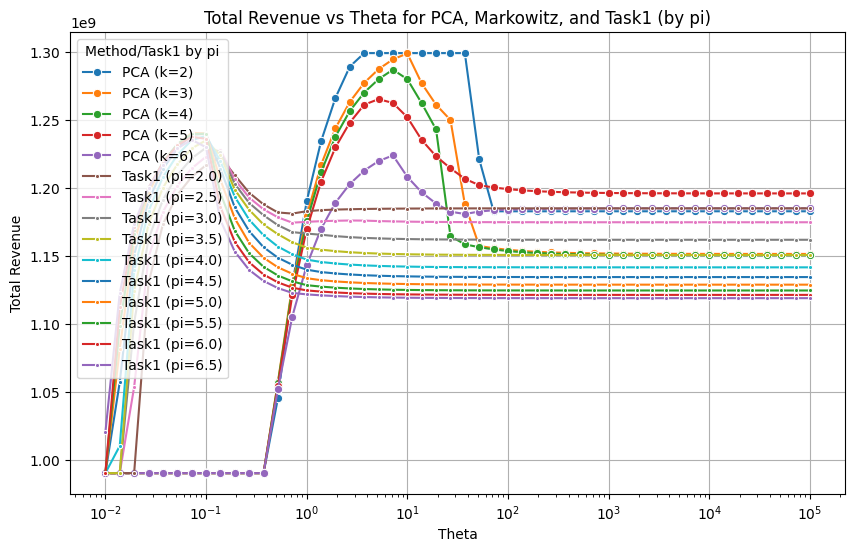

In [ ]:
# Filter the DataFrame for the PCA, Markowitz, and Task1 strategies
df_pca = strategy_set[strategy_set['method'] == 'PCA']
df_task1 = strategy_set[strategy_set['method'] == 'Task1']

# Plot the data
plt.figure(figsize=(10, 6))

# Line plots for PCA strategy
for k in df_pca['k'].unique():
    df_pca_k = df_pca[df_pca['k'] == k]
    sns.lineplot(data=df_pca_k, x='theta', y='total_revenue', label=f'PCA (k={k})', marker='o')

# Line plot for each unique value of pi in Task1
for pi_value in df_task1['pi'].unique():
    df_task1_pi = df_task1[df_task1['pi'] == pi_value]
    sns.lineplot(data=df_task1_pi, x='theta', y='total_revenue', label=f'Task1 (pi={pi_value})', marker='.')

# Customize the plot
plt.title('Total Revenue vs Theta for PCA, Markowitz, and Task1 (by pi)')
plt.xlabel('Theta')
plt.ylabel('Total Revenue')
plt.xscale('log')  # If theta is on a logarithmic scale
plt.legend(title='Method/Task1 by pi')
plt.grid(True)

# Show the plot
plt.show()



In [ ]:
pd.set_option('display.max_colwidth', None)
df = strategy_set[(strategy_set['method'] == 'PCA') & (strategy_set['k'] == 5)]
best_strategy = df[(df['theta'] > 100) & (df['theta'] < 1000) ]
display(best_strategy)

,pi,theta,objective,weights,method,k,total_revenue
648,NaN,138.949549,0.010884,"[0.34530347563993696, 0.14374488556352072, 0.4342273294970217, 2.873135757086587e-17, 0.07672430929952068, 5.637851296924623e-18]",PCA,5,1.198397e+09
653,NaN,193.069773,0.015055,"[0.3435810957133926, 0.14536857852567064, 0.4232388435515668, -1.8933727469975375e-17, 0.08781148220936998, 3.7608262858090935e-18]",PCA,5,1.197762e+09
658,NaN,268.269580,0.020845,"[0.342345150883883, 0.14653721493021124, 0.4153322557940397, -9.474487031512976e-17, 0.09578537839186613, -4.3927128644608016e-18]",PCA,5,1.197303e+09
663,NaN,372.759372,0.028886,"[0.341456340335525, 0.1473777513865052, 0.4096412774993452, 9.420763966833372e-17, 0.10152463077862454, 6.945458409248449e-18]",PCA,5,1.196972e+09
668,NaN,517.947468,0.040055,"[0.3408142499242791, 0.14798326305033602, 0.40554588092530464, 6.8347088513949494e-18, 0.10565660610008015, 4.608706266010648e-18]",PCA,5,1.196734e+09
673,NaN,719.685673,0.055572,"[0.34035419080556195, 0.14841851834258243, 0.40259840091944876, -9.499737216019525e-17, 0.10862888993240699, -4.488480527059741e-18]",PCA,5,1.196562e+09


### Subplots to visualize portfolio weightings for different k in PCA

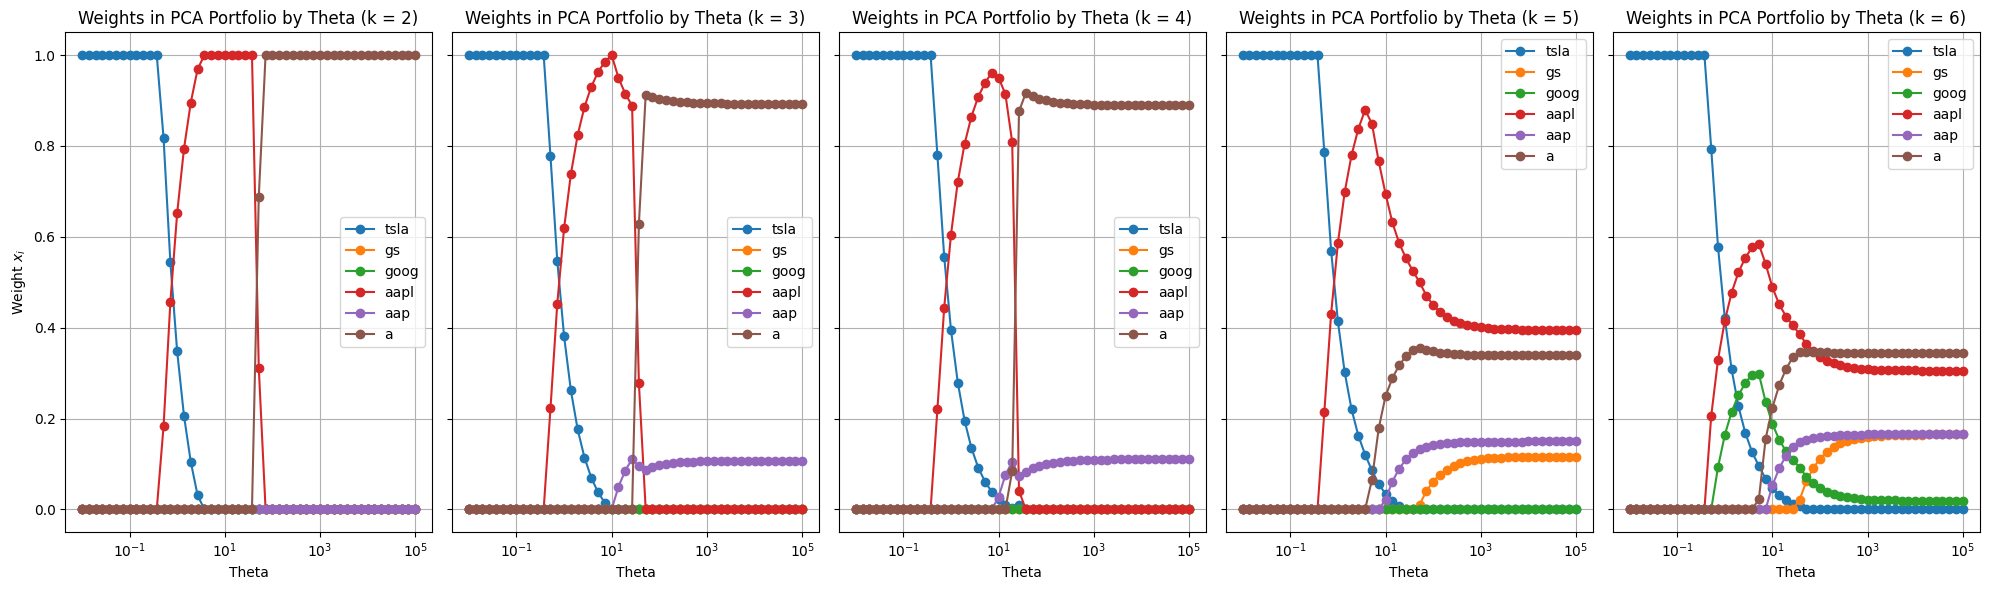

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# List of stock names corresponding to the weights in the array
stocks = ['tsla', 'gs', 'goog', 'aapl', 'aap', 'a']

# Create subplots for each k (5 subplots in one row)
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharey=True)

# Iterate over the desired k values (2 to 6) and plot them side by side
for idx, k in enumerate(range(2, 7)):
    test_table = results_pca[results_pca['k'] == k]
    temp_table = pd.DataFrame()

    # Extract the weights for each stock and add as columns to the DataFrame
    for i, stock in enumerate(stocks, 1):
        temp_table[stock] = test_table['weights'].apply(lambda w: w[-i])

    # Plot the weights by theta for each stock
    ax = axes[idx]
    for stock in stocks:
        ax.plot(test_table['theta'], temp_table[stock], marker='o', label=stock)

    # Set titles and labels
    ax.set_title(f'Weights in PCA Portfolio by Theta (k = {k})')
    ax.set_xlabel('Theta')
    ax.set_xscale('log')  # If theta is on a logarithmic scale
    if idx == 0:
        ax.set_ylabel(r'Weight $x_i$')  # Only set y-axis label on the first plot
    ax.legend()
    ax.grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


## <span style='color:red'>Task 4: Benchmark</span> ##



In [ ]:
start_date = '2019-07-01'
end_date = '2020-01-01' # exclude for end date, if do '2019-12-31' will get up to '2019-12-30'
asset_lst = ['GOOG', 'TSLA', 'AAPL', 'GS', 'A', 'AAP']

#Get data for new period and preprocess it
MyData_benchmark = yfin.download(asset_lst, start=start_date, end=end_date)
MyData_benchmark = MyData_benchmark.dropna()

MyData_close_benchmark = MyData_benchmark['Close']
MyData_open_benchmark = MyData_benchmark['Open']

#Generate new daily returns for the benchmark task
daily_returns_benchmark = (MyData_close_benchmark - MyData_open_benchmark) / MyData_open_benchmark
dates_benchmark = daily_returns_benchmark.index

#Select the best strategy from Task 3
#We picked a PCA strategy with k=5 factors, and a theta value of 139 and called it our 'best' strategy
#This was the lowest theta that we felt comfortable with, while still having higher returns than other models
#We also took the strategy that had the maximum revenue from the modeling period, and called it our 'max' strategy

max_strategy = strategy_set.loc[strategy_set['total_revenue'].idxmax()]
best_strategy = strategy_set.loc[648]

best_portfolio_weights = best_strategy['weights']
print('\nbest_portfolio_weights:',[round(value,5) for value in best_portfolio_weights])
max_portfolio_weights = max_strategy['weights']
print('max_portfolio_weights:',[round(value,5) for value in max_portfolio_weights])


# Calculate the portfolio's daily returns given weights and daily returns data
def calculate_portfolio_returns(portfolio_weights, daily_returns):
    portfolio_value = 1e9
    portfolio_returns = []
    portfolio_positions = portfolio_value * weights  # Initial positions based on weights
    # Loop through each date in the daily returns dataframe
    # Calculate the portfolio's return for the day by taking the dot product of weights and returns
    for date in daily_returns.index:
        returns_on_date = daily_returns.loc[date].values
        daily_portfolio_return = np.dot(portfolio_weights, returns_on_date)
        portfolio_returns.append(daily_portfolio_return)
        portfolio_positions *= (1 + returns_on_date) # Update the value of each position based on the daily returns
        portfolio_value = portfolio_positions.sum() #Total portfolio value at the end of the day
        portfolio_positions = portfolio_value * portfolio_weights  # Rebalance to maintain target weights tomorrow

    return portfolio_returns, portfolio_value

best_portfolio_returns_benchmark = calculate_portfolio_returns(best_portfolio_weights, daily_returns_benchmark)
max_portfolio_returns_benchmark = calculate_portfolio_returns(max_portfolio_weights, daily_returns_benchmark)


# Compute the average return of the portfolio across all the dates
best_returns = best_portfolio_returns_benchmark[0]
best_average_return = sum(best_returns) / len(best_returns)
best_revenue = best_portfolio_returns_benchmark[1]

max_returns = max_portfolio_returns_benchmark[0]
max_average_return = sum(max_returns) / len(max_returns)
max_revenue = max_portfolio_returns_benchmark[1]
print()

print("For our selected best strategy:")
print(f"The average daily 2019-07-01 to 2019-12-31 is {best_average_return:.6f}, or {100*best_average_return:.6f}%")

print("For the max strategy:")
print(f"The average daily 2019-07-01 to 2019-12-31 is {max_average_return:.6f}, or {100*max_average_return:.6f}%")

[*********************100%***********************]  6 of 6 completed


best_portfolio_weights: [0.3453, 0.14374, 0.43423, 0.0, 0.07672, 0.0]
max_portfolio_weights: [0.0, -0.0, 1.0, 0.0, 0.0, -0.0]

For our selected best strategy:
The average daily 2019-07-01 to 2019-12-31 is 0.000824, or 0.082443%
For our max strategy:
The average daily 2019-07-01 to 2019-12-31 is 0.001584, or 0.158377%


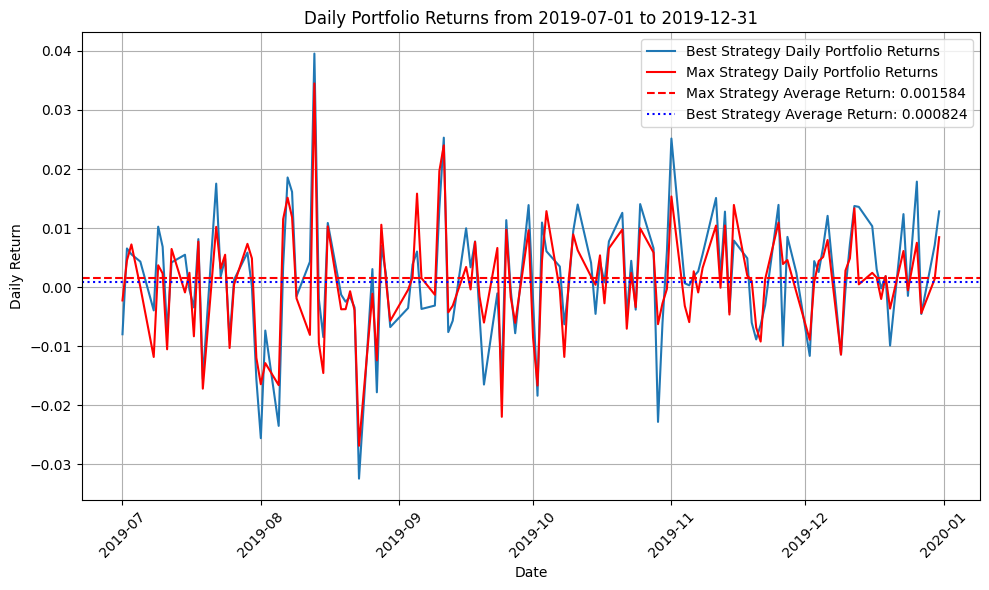

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(dates_benchmark, max_portfolio_returns_benchmark[0], label='Best Strategy Daily Portfolio Returns')
plt.plot(dates_benchmark, best_portfolio_returns_benchmark[0], color='r', label='Max Strategy Daily Portfolio Returns')
plt.axhline(y=max_average_return, color='r', linestyle='--', label=f'Max Strategy Average Return: {max_average_return:.6f}')
plt.axhline(y=best_average_return, color='b', linestyle='dotted', label=f'Best Strategy Average Return: {best_average_return:.6f}')
plt.title('Daily Portfolio Returns from 2019-07-01 to 2019-12-31')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()